In [1]:
!pip install -q transformers google-generativeai pandas

import google.generativeai as genai
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
import json
import time
import os

# --- 1. CẤU HÌNH ĐƯỜNG DẪN (EM SỬA LẠI TÊN DATASET Ở ĐÂY) ---

# Model 1: Baseline (Không có synthetic data)
PATH_MODEL_1 = "/kaggle/input/model-no-syndata/final_model"

# Model 2: Augmented (Có synthetic data)
# Em tìm đường dẫn bên thanh Input rồi paste vào đây nhé
PATH_MODEL_2 = "/kaggle/input/model-w-syndata/final_model" 

# Kiểm tra xem đường dẫn có đúng không
if not os.path.exists(PATH_MODEL_1) or not os.path.exists(PATH_MODEL_2):
    print("❌ Lỗi: Một trong hai đường dẫn model không tồn tại.")
    print(f"Kiểm tra Model 1: {os.path.exists(PATH_MODEL_1)}")
    print(f"Kiểm tra Model 2: {os.path.exists(PATH_MODEL_2)}")
else:
    print("✅ Đã tìm thấy cả 2 model!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 13.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.10.0 w

2025-12-02 02:06:48.010157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764641208.315562      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764641208.412416      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Đã tìm thấy cả 2 model!


In [2]:
# --- 2. LOAD 2 MODEL LÊN (Dùng CPU để tiết kiệm và tránh OOM) ---
print("\n🔄 Đang load Model 1 (Baseline)...")
translator_1 = pipeline("translation", model=PATH_MODEL_1, tokenizer=PATH_MODEL_1, device=-1)

print("🔄 Đang load Model 2 (Augmented)...")
translator_2 = pipeline("translation", model=PATH_MODEL_2, tokenizer=PATH_MODEL_2, device=-1)

print("\n🎉 Đã load xong cả 2 đấu thủ!")


🔄 Đang load Model 1 (Baseline)...


Device set to use cpu


🔄 Đang load Model 2 (Augmented)...


Device set to use cpu



🎉 Đã load xong cả 2 đấu thủ!


In [3]:
def compare_models(text, direction="en_vi"):
    """
    So sánh kết quả dịch của 2 model (Dạng in text đầy đủ).
    """
    # 1. Thêm Prefix chuẩn
    if direction == "en_vi":
        input_text = f"dịch Anh sang Việt: {text}"
        label_dir = "🇬🇧 ANH -> 🇻🇳 VIỆT"
    elif direction == "vi_en":
        input_text = f"dịch Việt sang Anh: {text}"
        label_dir = "🇻🇳 VIỆT -> 🇬🇧 ANH"
    else:
        print("❌ Lỗi: direction phải là 'en_vi' hoặc 'vi_en'")
        return

    # 2. Chạy dự đoán
    try:
        # Model Baseline
        out_baseline = translator_1(input_text, max_new_tokens=128)[0]['translation_text']
        
        # Model Augmented
        out_augmented = translator_2(input_text, max_new_tokens=128)[0]['translation_text']
        
        # 3. IN KẾT QUẢ (Dạng Text rõ ràng)
        print("=" * 60)
        print(f"📌 TEST: {label_dir}")
        print(f"📥 Input:     {text}")
        print("-" * 60)
        print(f"1️⃣ Baseline:  {out_baseline}")
        print(f"2️⃣ Augmented: {out_augmented}")
        print("=" * 60)
        print("\n") # Xuống dòng cho thoáng
        
    except Exception as e:
        print(f"❌ Có lỗi khi chạy model: {e}")

# --- CHẠY THỬ LẠI ---

# 1. Test lỗi Hallucination (Số liệu)
compare_models("The revenue reached $5.2 billion in 2023.", "en_vi")

# 2. Test lỗi Tên riêng
compare_models("Mr. Green lives in White House street.", "en_vi")

# 3. Test câu dài (Để kiểm tra xem có bị cắt không)
long_sentence = "Although artificial intelligence has made significant progress in recent years, there are still many challenges regarding ethics and data privacy that need to be addressed."
compare_models(long_sentence, "en_vi")

Your input_length: 26 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 26 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


📌 TEST: 🇬🇧 ANH -> 🇻🇳 VIỆT
📥 Input:     The revenue reached $5.2 billion in 2023.
------------------------------------------------------------
1️⃣ Baseline:  Số liệu ước tính cho năm 2023 là 5,2 tỷ USD vào năm 2023 . 
2️⃣ Augmented: Tổng doanh thu đạt 5,2 tỷ đô la vào năm 2023.




Your input_length: 58 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


📌 TEST: 🇬🇧 ANH -> 🇻🇳 VIỆT
📥 Input:     Mr. Green lives in White House street.
------------------------------------------------------------
1️⃣ Baseline:  Ông Green ở White House . 
2️⃣ Augmented: Ông Green ở White House.




Your input_length: 58 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


📌 TEST: 🇬🇧 ANH -> 🇻🇳 VIỆT
📥 Input:     Although artificial intelligence has made significant progress in recent years, there are still many challenges regarding ethics and data privacy that need to be addressed.
------------------------------------------------------------
1️⃣ Baseline:  Mặc dù công nghệ thông tin đã phát triển mạnh mẽ trong nhiều thập kỷ qua , vẫn còn rất nhiều vấn đề liên quan đến công nghệ và dữ liệu mà cần phải được giải quyết . 
2️⃣ Augmented: Mặc dù công nghệ thông tin đã phát triển mạnh mẽ trong những năm gần đây, vẫn còn nhiều vấn đề liên quan đến các hệ sinh thái và dữ liệu cần phải được giải quyết.




In [18]:
compare_models("Two apples are red.", "en_vi")

📌 TEST: 🇬🇧 ANH -> 🇻🇳 VIỆT
📥 Input:     Two apples are red.
------------------------------------------------------------
1️⃣ Baseline:  Hai chiếc còn lại là red . 
2️⃣ Augmented: Hai chiếc còn lại là màu đỏ.




In [11]:
# --- 3. CẤU HÌNH TRỌNG TÀI GEMINI ---
YOUR_API_KEY = ""
genai.configure(api_key=YOUR_API_KEY)

# Dùng model Flash cho nhanh
judge_model = genai.GenerativeModel('gemini-flash-latest')


def evaluate_translation(source, translation, direction="en_vi"):
    # Xác định ngôn ngữ nguồn
    if direction == "en_vi":
        lang_source = "English"
    else:
        lang_source = "Vietnamese"

    # --- PROMPT MỚI CỦA EM ---
    prompt = f"""
    You are a professional translation quality evaluator.

    Evaluate the following translation based on these criteria:
    1. **Fluency** (1-5): Is the translation grammatically correct and natural?
    2. **Accuracy** (1-5): Does it preserve the meaning of the source?
    3. **Coherence** (1-5): Is it logically consistent?
    4. **Relevance** (1-5): Is it contextually appropriate?

    Source ({lang_source}): {source}
    Translation: {translation}

    Respond ONLY in JSON format:
    {{
      "fluency": <score 1-5>,
      "accuracy": <score 1-5>,
      "coherence": <score 1-5>,
      "relevance": <score 1-5>,
      "overall": <average score>,
      "feedback": "<brief feedback in 1-2 sentences>"
    }}
    """
    
    try:
        response = judge_model.generate_content(prompt)
        text = response.text.strip()
        # Lọc lấy JSON chuẩn
        start = text.find('{')
        end = text.rfind('}') + 1
        if start != -1 and end != -1:
            return json.loads(text[start:end])
        else:
            return None
    except Exception as e:
        print(f"Lỗi API: {e}")
        return None

In [6]:
# --- TẬP TEST CASE HỖN HỢP (10 CÂU) ---

test_cases = [
    # --- PHẦN 1: ANH -> VIỆT (6 Câu) ---
    
    # 1. Test Số liệu & Đơn vị (Hallucination check)
    {
        "direction": "en_vi",
        "en": "The startup raised $4.5 million in Series A funding on October 12th.",
        "vi": "Startup đã huy động được 4,5 triệu đô la trong vòng gọi vốn Series A vào ngày 12 tháng 10."
    },
    # 2. Test Tên riêng & Địa danh (Không được dịch nghĩa đen 'Baker' thành 'Thợ làm bánh')
    {
        "direction": "en_vi",
        "en": "Mr. Baker works as a senior engineer at Apple Inc.",
        "vi": "Ông Baker làm việc với tư cách là kỹ sư cấp cao tại tập đoàn Apple."
    },
    # 3. Test Từ đa nghĩa (Context - 'Book' ở đây là đặt chỗ, không phải quyển sách)
    {
        "direction": "en_vi",
        "en": "I need to book a table for two at the restaurant.",
        "vi": "Tôi cần đặt một bàn cho hai người tại nhà hàng."
    },
    # 4. Test Từ đa nghĩa (Context - 'Running' ở đây là vận hành, không phải chạy bộ)
    {
        "direction": "en_vi",
        "en": "He is running a small business in downtown.",
        "vi": "Anh ấy đang điều hành một doanh nghiệp nhỏ ở trung tâm thành phố."
    },
    # 5. Test Câu lệnh/Cấu trúc phủ định (Grammar - Strict instruction)
    {
        "direction": "en_vi",
        "en": "Please do not open the package until you arrive home.",
        "vi": "Vui lòng không mở gói hàng cho đến khi bạn về đến nhà."
    },
    {
        "direction": "en_vi",
        "en": "Although artificial intelligence has made significant progress in recent years, there are still many challenges regarding ethics and data privacy that need to be addressed.",
        "vi": "Mặc dù trí tuệ nhân tạo đã có những tiến bộ đáng kể trong những năm gần đây, vẫn còn nhiều thách thức liên quan đến đạo đức và quyền riêng tư dữ liệu cần được giải quyết."
    },

    # --- PHẦN 2: VIỆT -> ANH (4 Câu) ---

    # 7. Test Số liệu & Mã hiệu (Hallucination check)
    {
        "direction": "vi_en",
        "vi": "Chuyến bay VN123 sẽ cất cánh lúc 14 giờ 30 phút.",
        "en": "Flight VN123 will take off at 14:30."
    },
    # 8. Test Địa danh Việt Nam (Entity check)
    {
        "direction": "vi_en",
        "vi": "Văn phòng của chúng tôi nằm tại quận Hoàn Kiếm, Hà Nội.",
        "en": "Our office is located in Hoan Kiem District, Hanoi."
    },
    # 9. Test Cấu trúc câu ghép (Structure check)
    {
        "direction": "vi_en",
        "vi": "Mặc dù trời mưa rất to, anh ấy vẫn đi làm đúng giờ.",
        "en": "Although it rained very heavily, he still went to work on time."
    },
    # 10. Test Văn phong giao tiếp (Context check)
    {
        "direction": "vi_en",
        "vi": "Cảm ơn bạn rất nhiều vì đã giúp đỡ tôi.",
        "en": "Thank you very much for helping me."
    }
]

In [12]:
comparison_data = []

print(f"📊 BẮT ĐẦU CHẤM ĐIỂM {len(test_cases)} CÂU...\n")

for i, case in enumerate(test_cases):
    direction = case["direction"]
    
    # Chuẩn bị input và reference
    if direction == "en_vi":
        src = case["en"]
        ref = case["vi"]
        input_text = f"dịch Anh sang Việt: {src}"
    else:
        src = case["vi"]
        ref = case["en"]
        input_text = f"dịch Việt sang Anh: {src}"
        
    try:
        # --- BƯỚC 1: CÁC MODEL DỊCH ---
        out_base = translator_1(input_text, max_new_tokens=128)[0]['translation_text']
        out_aug = translator_2(input_text, max_new_tokens=128)[0]['translation_text']
        
        # --- BƯỚC 2: CHẤM ĐIỂM TỪNG NGƯỜI ---
        # Chấm Baseline
        score_base = evaluate_translation(src, out_base, direction)
        time.sleep(1) # Nghỉ chút
        
        # Chấm Augmented
        score_aug = evaluate_translation(src, out_aug, direction)
        time.sleep(1)
        
        if score_base and score_aug:
            print(f"🔹 Câu {i+1}:")
            print(f"   - Baseline Overall: {score_base['overall']}/5")
            print(f"   - Augmented Overall: {score_aug['overall']}/5")
            
            # Lưu dữ liệu chi tiết
            comparison_data.append({
                "Input": src,
                "Ref": ref,
                # Điểm Baseline
                "B_Fluency": score_base['fluency'],
                "B_Accuracy": score_base['accuracy'],
                "B_Coherence": score_base['coherence'],
                "B_Relevance": score_base['relevance'],
                "B_Overall": score_base['overall'],
                "B_Feedback": score_base['feedback'],
                # Điểm Augmented
                "A_Fluency": score_aug['fluency'],
                "A_Accuracy": score_aug['accuracy'],
                "A_Coherence": score_aug['coherence'],
                "A_Relevance": score_aug['relevance'],
                "A_Overall": score_aug['overall'],
                "A_Feedback": score_aug['feedback']
            })
            
    except Exception as e:
        print(f"❌ Lỗi câu {i+1}: {e}")

Your input_length: 33 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


📊 BẮT ĐẦU CHẤM ĐIỂM 10 CÂU...



Your input_length: 33 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 22 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


🔹 Câu 1:
   - Baseline Overall: 4.25/5
   - Augmented Overall: 2.5/5


Your input_length: 22 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 22 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


🔹 Câu 2:
   - Baseline Overall: 4.5/5
   - Augmented Overall: 4.25/5


Your input_length: 22 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


🔹 Câu 3:
   - Baseline Overall: 2.25/5
   - Augmented Overall: 5.0/5


Your input_length: 21 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


🔹 Câu 4:
   - Baseline Overall: 4.5/5
   - Augmented Overall: 1.75/5


Your input_length: 21 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 58 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


🔹 Câu 5:
   - Baseline Overall: 4.75/5
   - Augmented Overall: 5.0/5


Your input_length: 58 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 23 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


🔹 Câu 6:
   - Baseline Overall: 3.25/5
   - Augmented Overall: 2.5/5


Your input_length: 23 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 20 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


🔹 Câu 7:
   - Baseline Overall: 1.5/5
   - Augmented Overall: 1.8/5


Your input_length: 20 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 21 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


🔹 Câu 8:
   - Baseline Overall: 2.8/5
   - Augmented Overall: 2.8/5


Your input_length: 21 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


🔹 Câu 9:
   - Baseline Overall: 1.0/5
   - Augmented Overall: 1.0/5
🔹 Câu 10:
   - Baseline Overall: 3.25/5
   - Augmented Overall: 2.5/5



📋 BẢNG ĐIỂM TRUNG BÌNH (THANG 5):


,Tiêu chí,Baseline (TB),Augmented (TB),Cải thiện
0,Fluency,3.800,3.60,-0.200
1,Accuracy,2.000,2.10,0.100
2,Coherence,3.800,3.10,-0.700
3,Relevance,3.200,2.80,-0.400
4,Overall,3.205,2.91,-0.295


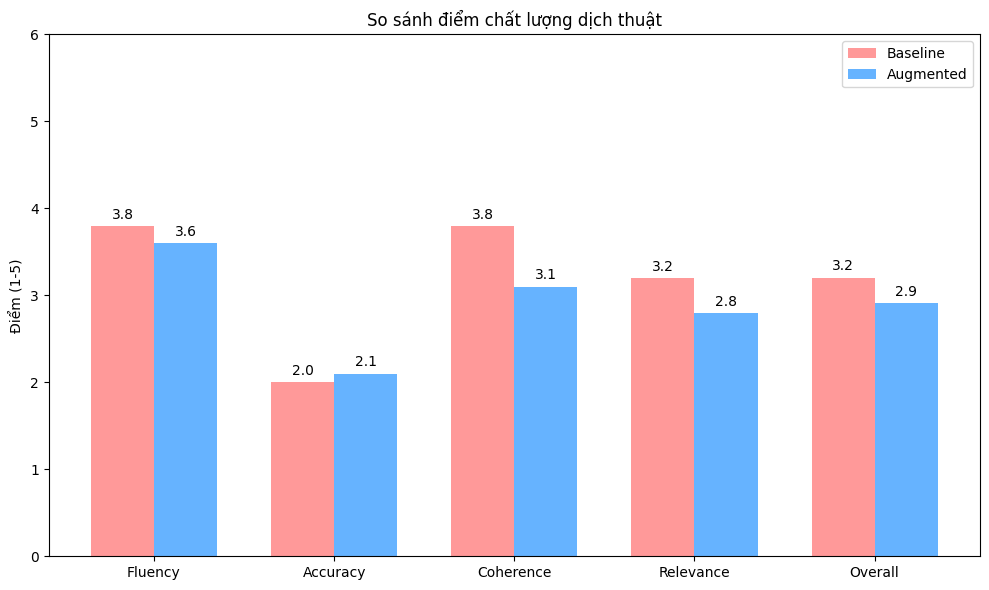

✅ Đã lưu kết quả chi tiết vào file 'final_evaluation_scores.csv'


In [15]:
if comparison_data:
    df_scores = pd.DataFrame(comparison_data)
    
    # Tính trung bình các cột điểm
    cols = ['Fluency', 'Accuracy', 'Coherence', 'Relevance', 'Overall']
    
    baseline_means = [df_scores[f'B_{c}'].mean() for c in cols]
    augmented_means = [df_scores[f'A_{c}'].mean() for c in cols]
    
    # Hiển thị bảng so sánh trung bình
    summary_df = pd.DataFrame({
        "Tiêu chí": cols,
        "Baseline (TB)": baseline_means,
        "Augmented (TB)": augmented_means,
        "Cải thiện": [a - b for a, b in zip(augmented_means, baseline_means)]
    })
    
    print("\n📋 BẢNG ĐIỂM TRUNG BÌNH (THANG 5):")
    display(summary_df)
    
    # Vẽ biểu đồ Grouped Bar Chart
    x = np.arange(len(cols))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, baseline_means, width, label='Baseline', color='#ff9999')
    rects2 = ax.bar(x + width/2, augmented_means, width, label='Augmented', color='#66b3ff')
    
    ax.set_ylabel('Điểm (1-5)')
    ax.set_title('So sánh điểm chất lượng dịch thuật')
    ax.set_xticks(x)
    ax.set_xticklabels(cols)
    ax.set_ylim(0, 6)
    ax.legend()
    
    ax.bar_label(rects1, padding=3, fmt='%.1f')
    ax.bar_label(rects2, padding=3, fmt='%.1f')
    
    plt.tight_layout()
    plt.show()
    
    # Lưu kết quả ra CSV để báo cáo
    df_scores.to_csv("final_evaluation_scores.csv", index=False)
    print("✅ Đã lưu kết quả chi tiết vào file 'final_evaluation_scores.csv'")

else:
    print("Không có dữ liệu để vẽ biểu đồ.")